In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import TrainableEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

[Qibo 0.2.17|INFO|2025-04-02 18:26:51]: Using qiboml (pytorch) backend on cpu


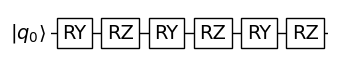

In [28]:
set_backend("qiboml", platform="pytorch")

nqubits = 1
nlayers = 3

gates_list = []
for _ in range(nlayers):
    gates_list.extend([gates.RY, gates.RZ])

class LinEncoding(nn.Module):
    """Activation function which helps in giving more sensitivity around zero."""
    def __init__(self):
        super(LinEncoding, self).__init__()
        self.param1 = nn.Parameter(torch.tensor(np.random.randn()))
        self.param2 = nn.Parameter(torch.tensor(np.random.randn()))
    
    def forward(self, x):
        return self.param1 * x + self.param2 

circuit_structure = []
for k in range(2 * nlayers):
    circuit_structure.append(
        TrainableEncoding(
            nqubits=nqubits,
            encoding_gate=gates_list[k],
            encoding_rule=LinEncoding()
        )
    )

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("qiboml", platform="pytorch")
)
# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
)

_ = model.draw()

In [29]:
model(torch.tensor(0.5))

tensor([[-0.3648]], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [30]:
# Prepare the training dataset (using f(x) = sin(x) as the target function)
def f(x):
    return 1 * torch.sin(x)  ** 2 - 0.3 * torch.cos(x) 

num_samples = 30
x_train = torch.linspace(0, 2 * np.pi, num_samples, dtype=torch.float64).unsqueeze(1)
y_train = f(x_train)

y_train = 2 * ( (y_train - min(y_train)) / (max(y_train) - min(y_train)) - 0.5 )

In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [32]:
epochs = 150
for epoch in range(epochs):
    optimizer.zero_grad()
    # Use torch.stack to get a tensor of shape (100, 1, 1)
    y_pred = torch.stack([model(x) for x in x_train])
    # Remove the extra singleton dimension so that y_pred has shape (100, 1)
    y_pred = y_pred.squeeze(-1)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 0.5993975481284752
Epoch 10: Loss = 0.12252327845965834
Epoch 20: Loss = 0.07329363271579338
Epoch 30: Loss = 0.07043200035156119
Epoch 40: Loss = 0.0588899228983448
Epoch 50: Loss = 0.04871306095020045
Epoch 60: Loss = 0.0385619181796812
Epoch 70: Loss = 0.032604775809823947
Epoch 80: Loss = 0.02820677441691633
Epoch 90: Loss = 0.02133313950283989
Epoch 100: Loss = 0.011316878169964243
Epoch 110: Loss = 0.007488550917430618
Epoch 120: Loss = 0.005002061413425241
Epoch 130: Loss = 0.003815110873085329
Epoch 140: Loss = 0.003180398051808933


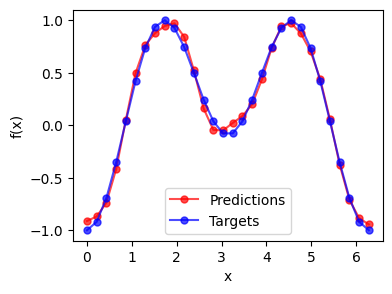

In [34]:
plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train, 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x_train, 
    y_train,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.xlabel(r"x")
plt.ylabel(r"f(x)")
plt.legend()
plt.show()